# Genetic Programming for Regression

This notebook shows a simple example on how to use TurboGP library to perform regression tasks. The steps shown here can be considered as the standard procedure to use TurboGP for supervised Machine Learning Tasks.

This notebook can be used as a template to tackle scalar regression problems in general, with very minor modifications.

This notebook can be considered as the general introductory guide to TurboGP.

First, let's declare the libraries we will be using:

In [1]:
%matplotlib notebook

# Required Python libraries
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from networkx.drawing.nx_agraph import graphviz_layout

# TurboGP libraries
from GPIndividuals import *      
from GPOperators import *        
from GPflavors import *          
from LowLevel import *           
from Mezzanine import *          
from HighLevel import *          
from Trimmers import *           
from GPUtils import *            
from Utils import *              

from Regressor import *          # GP individual we will use

# This is useful for when there is overflow, so output cells do not fill with warning messages.
# Disable to debug
import warnings
warnings.simplefilter('ignore')

Now, let's create a dataset to use it to train a model with TurboGP.
We will keep it simple for now, we will attempt to generate a model that approximates the following function:

<center>$y = sin(x)$</center>

## Sample dataset creation

First, let's create a training dataset, composed of 1000 random samples, in the range of $[-\pi,\pi]$.

In [2]:
# Training set

# samples
x_training = np.random.rand(1000,1)
x_training = (x_training * 6.28) - 3.14

# labels
y_training = np.sin(x_training).flatten()

Let's see our training samples and labels:

In [3]:
for i in range(len(x_training)):
    print('sin({:.3f}) = {:.3f}'.format(x_training[i][0], y_training[i]))

sin(1.991) = 0.913
sin(-0.628) = -0.587
sin(3.033) = 0.108
sin(-2.740) = -0.391
sin(0.685) = 0.633
sin(-2.269) = -0.766
sin(0.764) = 0.692
sin(1.016) = 0.850
sin(-1.552) = -1.000
sin(1.197) = 0.931
sin(-2.384) = -0.687
sin(-3.037) = -0.104
sin(-2.267) = -0.767
sin(1.475) = 0.995
sin(-0.433) = -0.420
sin(-2.030) = -0.897
sin(1.656) = 0.996
sin(-0.176) = -0.175
sin(2.523) = 0.580
sin(1.521) = 0.999
sin(2.052) = 0.887
sin(0.945) = 0.810
sin(-0.912) = -0.791
sin(-0.646) = -0.602
sin(1.198) = 0.931
sin(-1.628) = -0.998
sin(1.569) = 1.000
sin(2.230) = 0.791
sin(-1.537) = -0.999
sin(0.534) = 0.509
sin(2.155) = 0.834
sin(-2.169) = -0.827
sin(1.184) = 0.926
sin(2.421) = 0.660
sin(-1.972) = -0.920
sin(1.231) = 0.943
sin(2.995) = 0.146
sin(0.883) = 0.773
sin(-2.595) = -0.520
sin(1.959) = 0.926
sin(-1.391) = -0.984
sin(-1.947) = -0.930
sin(-1.813) = -0.971
sin(1.112) = 0.897
sin(-3.104) = -0.037
sin(0.794) = 0.713
sin(-2.361) = -0.704
sin(0.821) = 0.732
sin(-2.894) = -0.245
sin(-2.653) = -0.470
si

Let's also create a testing dataset, that we will use to measure our models out-of-sample performance (validation). We will generate only 200 points for the testing dataset.

In [4]:
# Testing set

# samples
x_testing = np.random.rand(200,1)
x_testing = (x_testing * 6.28) - 3.14

# labels
y_testing = np.sin(x_testing).flatten()

##  TurboGP setup

Now let's configure some global variables required for TurboGP. These are the standard GP hyperparameters, such as: population size, genetic operations used, etc.

The very first thing we need to setup in TurboGP, is the primitives set. TurboGP supports different types of primitives, but for this example we only need to use standard primitives typically used in any generic GP, such as arithmetic operations, etc. For more details on the different types of primitives supported by TurboGP, refer to notebook 00. 

Here, within the context of TurboGP, standard primitives are called 'Low Level' primitives:

In [5]:
# Each of these functions must be properly defined in the corresponding python modules.
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'X2', 'MAX', 'MEAN', 'MIN', 'RELU']
mezzanine = None
highlevel = None


# Now we let the Node objects know the set of input based primitives available at each layer.
Node.f1_set=lowlevel
Node.f2_set=mezzanine
Node.f3_set=highlevel

# This is the range of constants leaf nodes can take a value from (when not taking the form of a input variable)
Node.i2_set=[-1.0,1.0]

We included in our set of GP primitives binary arithmetic operations $[+, -, \times, \div]$, square $x^2$, the max of two numbers, the mean of two numbers, the minimum of two numbers, and the rectifier, which is defined as $max(0,x)$.

Notice how we did not employ sine or cosine functions. Sine and other trigonometric functions are typical primitives in GP. However, we do not want GP to find "the answer we already knew" to the problem, but rather we want GP to find a way (learn) to approximate a sine function with only arithmetic operations and few other simple computational functions as commodities (imagine we are trying to find how to implement trigonometric functions in a very small CPU without hardware implementations).

Now we will specify the rest of the hyperparameters needed for a GP run:

In [6]:
pop_size = 1000                                  # Population size

oper = [SimpleRegresor.mutation,                 # Genetic operations to use.
        SimpleRegresor.protected_crossover]      # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                             # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                              # How many parents required by each operation.

l_rate = 1.0                                     # Offspring pool size, defined as the ratio to the population size.

minimization = True                              # if it is a minimization problem or not
sel_mechanism = binary_tournament                # Preferred selection mechanism for parent selection

Notice how the number of generations has not been defined yet. This will be setup later on.
Notice also how the selection mechanism applies only for parent selection, not for survivor selection; this is because, in GP, survivor selection usually can take only two forms, steady state or generational replacement.

## Creation of initial population

Now we can create the initial population, composed of randomly generated individuals. SimpleRegresor individuals require that we specify the size of the input (1 in this case), and the max tree depth. We will use a max tree depth of 7, which is more than enough for the simple problem being treated here.

In [7]:
%%time
Population = []

for _ in range(pop_size):
    Population.append(SimpleRegresor(input_vector_size=1,
                                   complexity = 7))

CPU times: user 932 ms, sys: 72 ms, total: 1 s
Wall time: 943 ms


That's it. We have created the first generation of random individuals of the SimpleRegresor class. We need to perform on them an initial evaluation, before we can proceed to the evolutionary cycle:

In [8]:
%%time
#initial evaluation
for individual in Population:
        individual.fitness(x_training, y_training)

CPU times: user 8.4 s, sys: 0 ns, total: 8.4 s
Wall time: 8.4 s


As we can see, the evaluation of the entire population of 1000 individuals took only a few seconds on the full training dataset. Now that the first population is evaluated, we can proceed to the evolutionary iteration.

## Evolutionary Cycle

We can define now the number of generations we would like our GP to run for. We will also create some empty lists in which will be storing resulting statistics from each generation, such as best fitness, best testing fitness and diversity.

In [9]:
Generations = 50                             

diversity = []
fitness = []
test_fitness = []

A complete evolutionary run is performed by simply calling repeatedly a method that implements some population dynamics, such as Steady_State, as implemented in GPflavors.py file. The methods receives as input the current population, a training dataset, a testing dataset (optional) and some of the evolutionary hiperparameters we defined beforehand; it returns as output the next gen population, and some values indicating training and testing fitness, and diversity. 

So we just need to call such method for the number of evolutionary cycles we want, and each time we will pass the current population as argument, and the output population returned by the method, will use it to override the population we just passed. That's how evolutionary cycles elaps in TurboGP.

<IPython.core.display.Javascript object>


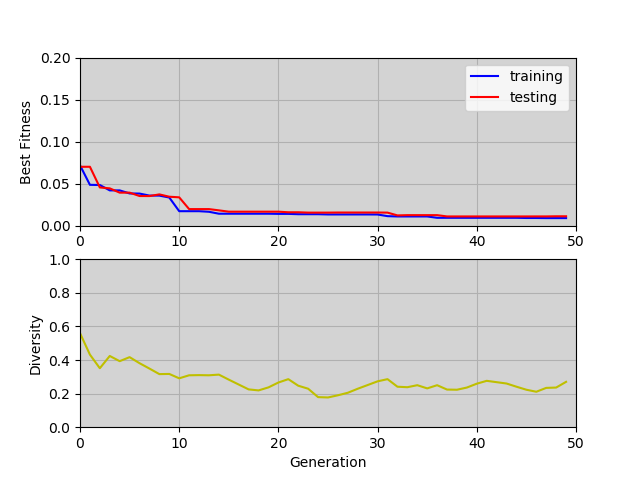

100%|██████████| 50/50 [13:27<00:00, 16.15s/it]


In [10]:
############################################################################################################
# The following piece of code, will allow us to display -in real time- the progress of training fitness,   #
# testing fitness and diversity decay. It is a bit overcomplicated, and it is optional of course, but it   #
# is very useful to understand and visualize if the GP is achieving convergence.                           #

x = list(range(Generations))                                                                               #

y = np.empty(Generations)                                                                                  #
y[:]=np.nan                                                                                                #
y2 = np.empty(Generations)                                                                                 #
y2[:]=np.nan                                                                                               #
d3 = np.empty(Generations)                                                                                 #
d3[:]=np.nan                                                                                               #

plt.ion()                                                                                                  #
fig = plt.figure()                                                                                         #
ax = fig.add_subplot(211)                                                                                  # 
ax.set_ylabel('Best Fitness')                                                                              #
ax.set_ylim(0.0,0.2)                                                                                       #
ax.set_xlim(0,Generations)                                                                                 #
ax.set_facecolor('lightgray')                                                                              #  
ax.grid(True)                                                                                              #
ax2 = fig.add_subplot(212)                                                                                 #
ax2.set_xlabel('Generation')                                                                               #
ax2.set_ylabel('Diversity')                                                                                #
ax2.set_ylim(0.0,1.0)                                                                                      #
ax2.set_xlim(0,Generations)                                                                                #
ax2.set_facecolor('lightgray')                                                                             #
ax2.grid(True)                                                                                             #

line1, = ax.plot(x, y, 'b-', label='training')                                                             #
line2, = ax.plot(x, y2, 'r-', label='testing')                                                             #
line3, = ax2.plot(x, d3, 'y-')                                                                             #
ax.legend()                                                                                                #
############################################################################################################

pbar = tqdm.tqdm(total=Generations)                         # We can also use tqdm to display a progress bar


for i in range(Generations):
        
    Population, d, bf, tf = Steady_State(Population = Population,
                                         batch = x_training,
                                         labels = y_training,
                                         test_batch = x_testing,
                                         test_labels = y_testing,
                                         l_rate = l_rate,
                                         oper = oper,
                                         oper_prob = oper_prob,
                                         oper_arity = oper_arity,
                                         minimization = minimization,
                                         sel_mechanism = sel_mechanism,
                                         online = False)
        
    diversity.append(d)
    fitness.append(bf)
    test_fitness.append(tf)
    
    # For live plotting #################
    y[i]=fitness[i]
    y2[i]=test_fitness[i]
    d3[i]=diversity[i]
    
    line1.set_ydata(y)
    line2.set_ydata(y2)
    line3.set_ydata(d3)
    
    fig.canvas.draw()
    #####################################
    
    pbar.update(1)      
    
pbar.close()

Now that the evolutionary run has completed, we can see what was the best fitness achieved, both in training and testing datasets, simply by looking at the last entry of the lists in which we stored such statistics:

In [11]:
print("Training fitness of best individual found: ", fitness[-1])
print("Testing  fitness of best individual found: ", test_fitness[-1])

Training fitness of best individual found:  0.008928389630413166
Testing  fitness of best individual found:  0.011085445821817988


The results are expressed in MSE, which is the error measure used by SimpleRegresor class.

Let's extract the best individual from the population in order to display its syntax tree. For this, we will use elite selection method, configuring it to 1:

In [12]:
solver = elite_selection(population=Population, amount=1, minimization=minimization)[0]

Now, let's plot it and see how it looks...

<IPython.core.display.Javascript object>


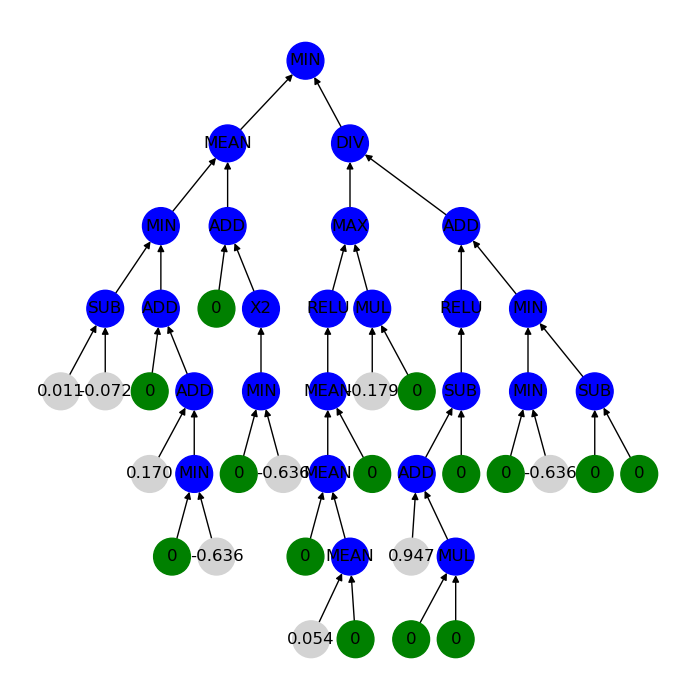

In [13]:
plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(solver.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

Finally, let's see how does it look the curve that our models approximates, and compare it against the real function...

<IPython.core.display.Javascript object>


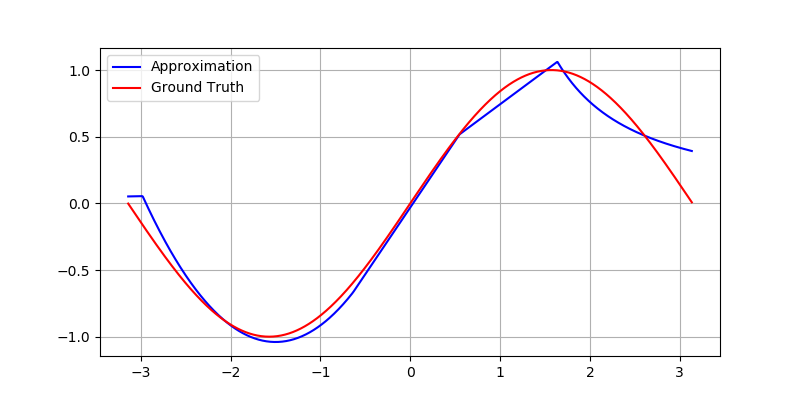

In [14]:
x = np.arange(1000)
x = ((x / 1000) * 6.28) - 3.14
x = x.reshape(1000,1)

y = np.zeros(1000)
y2 = np.zeros(1000)

for i in range(1000):
    y[i] = solver.predict(x[i])
    y2[i] = np.sin(x[i])


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.grid(True)

line1, = ax.plot(x, y, 'b-', label='Approximation')
line2, = ax.plot(x, y2, 'r-', label='Ground Truth')

ax.legend()
plt.show()